# **Sentiment Analysis: Youtube Comments**

## 1. Loading Required Libraries

In [422]:
#Importing all Important Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import gensim
import speech_recognition as sr
import nltk
from gensim.parsing.preprocessing import remove_stopwords, STOPWORDS
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import seaborn as sns
from plotly import graph_objs as go
from wordcloud import WordCloud
import pickle
import warnings
warnings.filterwarnings("ignore")
nltk.download('wordnet')
nltk.download('wordnet2022')

[nltk_data] Downloading package wordnet to /Users/shreyas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet2022 to
[nltk_data]     /Users/shreyas/nltk_data...
[nltk_data]   Package wordnet2022 is already up-to-date!


True

## 2. Data Collection & Exploratory Data Analysis

### 2.1 Loading the dataset

In [423]:
#Loading the dataset
youtube_comments = pd.read_csv('comments.csv')

In [424]:
#Displaying top 5 rows of our dataset
youtube_comments.head()

,Unnamed: 0,Video ID,Comment,Likes,Sentiment
0,0,wAZZ-UWGVHI,Let's not forget that Apple Pay in 2014 requir...,95.0,1.0
1,1,wAZZ-UWGVHI,Here in NZ 50% of retailers don’t even have co...,19.0,0.0
2,2,wAZZ-UWGVHI,I will forever acknowledge this channel with t...,161.0,2.0
3,3,wAZZ-UWGVHI,Whenever I go to a place that doesn’t take App...,8.0,0.0
4,4,wAZZ-UWGVHI,"Apple Pay is so convenient, secure, and easy t...",34.0,2.0


Column **'Sentiment'** is the sentiment of the comment.
> 0, 1, 2 represents a negative, neutral and positive sentiments respectively.

### 2.2 Bar Chart representing number of samples for each Sentiment

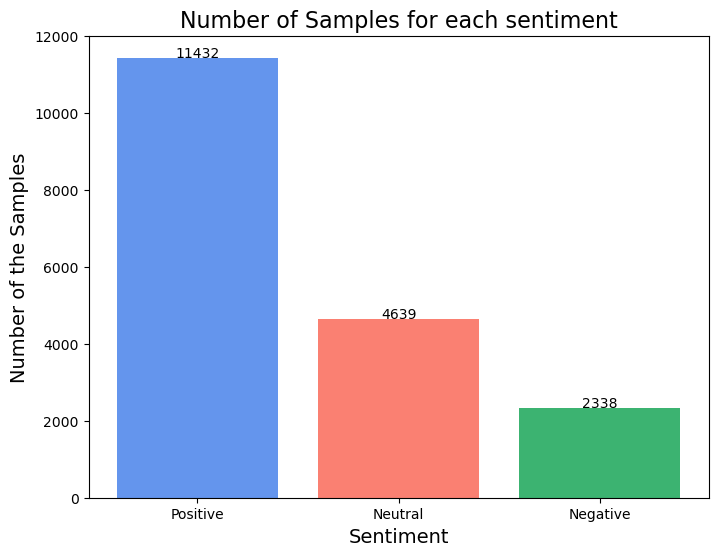

In [425]:
colors = ['cornflowerblue', 'salmon', 'mediumseagreen']
counting = youtube_comments.Sentiment.value_counts() #counting sentiment values
plt.figure(figsize=(8, 6))
plt.bar(['Positive', 'Neutral', 'Negative'],counting, color=colors)
plt.xlabel('Sentiment', fontsize=14)
plt.ylabel('Number of the Samples', fontsize=14)
plt.title("Number of Samples for each sentiment", fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
for i, count in enumerate(counting):
    plt.text(i, count + 10, str(count), ha='center', fontsize=10)

plt.show()

#### Extracting the **'Comment'** and **'Sentiment'** columns for our analysis

In [426]:
# Extracting Comment & Sentiment columns
First_corpus = pd.DataFrame(columns=['Text','Label'])
First_corpus['Text'],First_corpus['Label'] = youtube_comments['Comment'],youtube_comments['Sentiment']

We will be doing *Binary Classification* for our dataset, hence we will drop the **Neutral Sentiment**.

In [427]:
# Dropping the Neutral Sentiment rows
First_corpus.drop(First_corpus[First_corpus['Label'] == 1.0].index, inplace=True)
# Assigning the Positive class (2.0) to (1.0)
First_corpus.loc[First_corpus['Label'] == 2.0, 'Label'] = 1.0

### 2.3 Analyzing youtube statistics dataset

In [428]:
#displaying top 40 rows of our processed corpus file
First_corpus.head(40)

,Text,Label
1,Here in NZ 50% of retailers don’t even have co...,0.0
2,I will forever acknowledge this channel with t...,1.0
3,Whenever I go to a place that doesn’t take App...,0.0
4,"Apple Pay is so convenient, secure, and easy t...",1.0
6,We only got Apple Pay in South Africa in 2020/...,1.0
8,"In the United States, we have an abundance of ...",1.0
10,"Wow, you really went to town on the PSU test r...",1.0
11,The lab is the most exciting thing in IT I've ...,1.0
12,"Linus, I'm an engineer and love the LMG conten...",1.0
13,There used to be a time where Linus was the sm...,1.0


In [429]:
First_corpus.Text.describe()

count                                                 13770
unique                                                13462
top       One of the best thing about Dude is that he\r\...
freq                                                     10
Name: Text, dtype: object

There are some **DUPLICATED TEXTS**, hence, we will drop them as well as **NULL VALUES**, if any.

In [430]:
First_corpus.drop_duplicates(inplace=True)
print(First_corpus.Text.is_unique)
print(f'Number of Samples after removing duplicates: {len(First_corpus)}')

True
Number of Samples after removing duplicates: 13462


In [431]:
First_corpus.dropna(inplace=True)
print(f'Number of Samples after removing null values: {len(First_corpus)}')

Number of Samples after removing null values: 13462


In [432]:
# To display Label Count and Total Number of Samples
df = First_corpus
print(df.Label.value_counts())
print(f'The number of total samples: {len(df)}')
df.head(10)

Label
1.0    11141
0.0     2321
Name: count, dtype: int64
The number of total samples: 13462


,Text,Label
1,Here in NZ 50% of retailers don’t even have co...,0.0
2,I will forever acknowledge this channel with t...,1.0
3,Whenever I go to a place that doesn’t take App...,0.0
4,"Apple Pay is so convenient, secure, and easy t...",1.0
6,We only got Apple Pay in South Africa in 2020/...,1.0
8,"In the United States, we have an abundance of ...",1.0
10,"Wow, you really went to town on the PSU test r...",1.0
11,The lab is the most exciting thing in IT I've ...,1.0
12,"Linus, I'm an engineer and love the LMG conten...",1.0
13,There used to be a time where Linus was the sm...,1.0


Analyzing the *distribution* of the dataset classes {Positive, Negative} to check if the data is balanced or imbalanced.

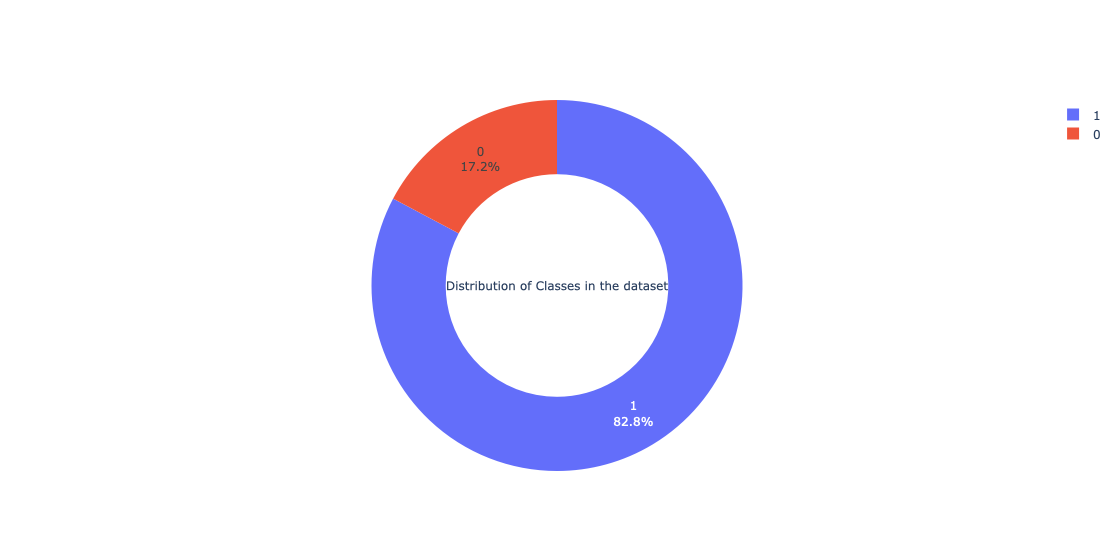

In [433]:
labels = df.groupby(df['Label']).size().index
values = df.groupby(df['Label']).size().values
fig = go.Figure(data=[go.Pie(labels=labels, 
                              values=values, 
                              hole=0.6,
                              textinfo='percent+label',  # Show percentages and labels
                              title='Distribution of Classes in the dataset')])

fig.update_layout(title_font_size=20, title_x=0.5,width=750,height=550)
fig.show()

## 3. Data Preparation & Cleaning

In [434]:
print(f"The total number of samples after dropping some {len(df)}")

The total number of samples after dropping some 13462


As our dataset incorporates *Social Media comments* for training our model, our corpus may contain **"Mentions @"**, **"Hashtags #"**, **"Emojis and Flags"**, **"Links & URLs"**, **"Symbols"**, **"Digits"**, **"Duplicated characters within the same word"** and **"Abbreviations"**

In [435]:
#Defining a function that remove unnecessary characters
def cleaning(text):
    text = re.sub(r'#\w+','', text)                 # Removing Hashtags
    text = re.sub(r'http\S+','', text)              # Removing Links & URLs
    text = re.sub(r'@\w+','', text)                 # Removing Mentions
    text = re.sub('[()!?.\';:<>`$%’,]', '', text)   # Removing Punctuations with different forms
    text = re.sub(r'[^a-zA-Z]',' ', text)           # Removing digits
    text = re.sub(r'([a-zA-Z])\1{2,}','\1', text)   # Reduce duplicated character (> 3) to only one
    return text

#Defining the most used list of Abbreviations to be expanded to its original form
abbreviations = {'fyi': 'for your information',
                 'lol': 'laugh out loud',
                 'loza': 'laughs out loud',
                 'lmao': 'laughing',
                 'rofl': 'rolling on the floor laughing',
                 'vbg': 'very big grin',
                 'xoxo': 'hugs and kisses',
                 'xo': 'hugs and kisses',
                 'brb': 'be right back',
                 'tyt': 'take your time',
                 'thx': 'thanks',
                 'abt': 'about',
                 'bf': 'best friend',
                 'diy': 'do it yourself',
                 'faq': 'frequently asked questions',
                 'fb': 'facebook',
                 'idk': 'i don\'t know',
                 'asap': 'as soon as possible',
                 'syl': 'see you later',
                 'nvm': 'never mind',
                 'frfr':'for real for real',
                 'istg':'i swear to god',
    }

In [436]:
#Data cleaning fucntion to call the above cleaning function, converting the characters to lower case 
#and expanding the most used abbreviations

def DataCleaning(corpus):
    corpus['Text'] = corpus['Text'].apply(cleaning)     # Calling cleaning function (1-7)
    corpus['Text'] = corpus['Text'].str.lower()         # Normalize all characters to lowercase
    for abbreviation, full_form in abbreviations.items(): # Expanding the Abbreviations
        corpus['Text'] = corpus['Text'].str.replace(abbreviation, full_form)
    return corpus

In [437]:
df = DataCleaning(df)

In [438]:
print(f"The total number of samples: {len(df)}")
df.drop_duplicates(inplace=True)                # Dropping duplicated texts if exist after Cleaning
df.dropna(inplace=True)                         # Dropping Null values if exist after Cleaning
print(f"The total number of samples after removal: {len(df)}")

The total number of samples: 13462
The total number of samples after removal: 13359


In [439]:
df.Text.describe()

count     13359
unique    13358
top            
freq          2
Name: Text, dtype: object

Utilizing **WordCloud** for the most frequent words in *"the whole dataset", "positive class" and finally the "negative class"*.

(-0.5, 1999.5, 1599.5, -0.5)

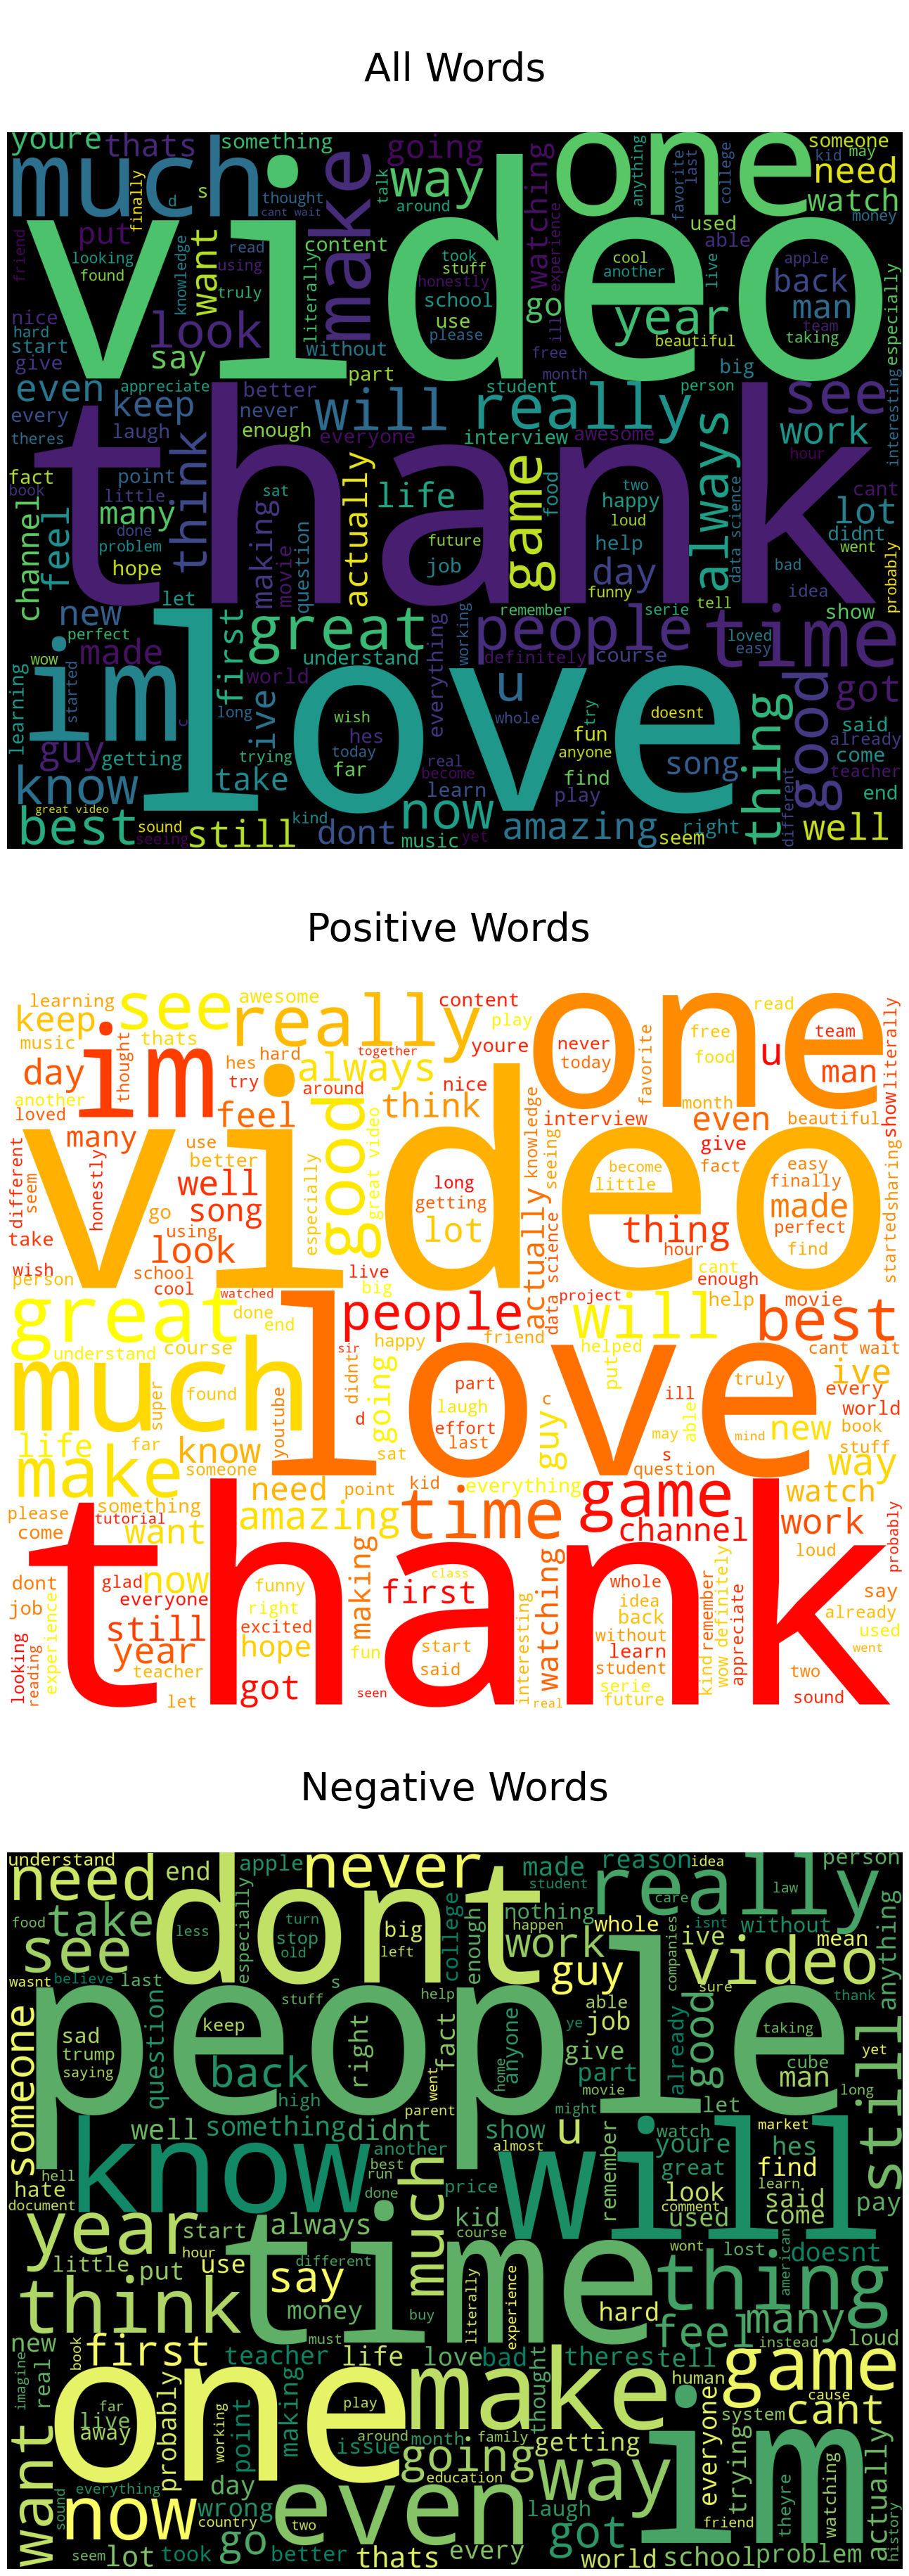

In [440]:
fig, ax = plt.subplots(3, 1, figsize  = (45,45))
all_words = WordCloud(
                        background_color='black',
                        width=2000,
                        height=1600,
                        colormap='viridis'
                         ).generate(' '.join(df['Text']))

positive_words =WordCloud(
                        background_color='white',
                        width=2000,
                        height=1600,
                        colormap='autumn'
                         ).generate(" ".join(df[df['Label']==1.0]['Text']))

negative_words =WordCloud(
                        background_color='black',
                        width=2000,
                        height=1600,
                        colormap='summer'
                         ).generate(" ".join(df[df['Label']==0.0]['Text']))

ax[0].imshow(all_words)
ax[0].set_title('\nAll Words\n', fontsize=40)
ax[0].axis('off')
print('\n')
ax[1].imshow(positive_words)
ax[1].set_title('\nPositive Words \n',fontsize=40)
ax[1].axis('off')
print('\n')
ax[2].imshow(negative_words)
ax[2].set_title('\nNegative Words\n',fontsize=40)
ax[2].axis('off')

## 4. Data Preprocessing

### 4.1 Removing Stop Words

In [441]:
df['Text'] = df['Text'].apply(remove_stopwords)

### 4.2 Tokenization

In [442]:
df['Tokenized'] = df['Text'].apply(word_tokenize)

### 4.3 Lemmatization with POS

Using lemmatization technique with Part-of-Speech (POS) to reduce the words to its original form!

In [443]:
#defining all Required Parameters for WordNet Lemmatizer (POS Tags Reducing - POS Tagging)
lemmatizer = WordNetLemmatizer()

#defining pos_tagger function to Reduce Nouns to N, Adjectives to J ... etc , for further processing
def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:         
        return None

#defining the lemmatization function
def lemmatization(text):
    new_sen = []
    pos_tagged = pos_tag(text)
    wordnet_tagged = list(map(lambda x: (x[0],pos_tagger(x[1])), pos_tagged)) # POS Tagging & Reducing
    for word, tag in wordnet_tagged:
        if tag is None:
            new_sen.append(word)
        else:
            new_sen.append(lemmatizer.lemmatize(word,tag))                   # Lemmatizing
            
    return new_sen

In [444]:
# Lemmatizing the Corpus
df['Tokenized'] = df['Tokenized'].apply(lemmatization)

In [445]:
# Regrouping the Words into sentences to detect if there are any duplicates or Null Values
df['Text'] = df['Tokenized'].apply(lambda x: " ".join(x))
print(f"The total number of samples: {len(df)}")

The total number of samples: 13359


## 5. Data Representation & Vectorization

### 5.1 TF-IDF Vectorization

In [446]:
vectorizer = TfidfVectorizer(strip_accents='ascii',analyzer='word',
                            smooth_idf=True, norm=None, min_df=10)

#For accurate vectorizing results, the Vectorizer is parameterized as the following
# strip_accents: characters not encoded in ASCII will be removed
# analyzer: the tokenization process will be re-applied as words
# smooth_idf: later in evaluation/testing, if any word doesn't exist, then the denominator of the TF-IDF Calculation will be 1
# min_df: to skip any word whose document frequency is less than 10

In [447]:
X = vectorizer.fit_transform(df['Text'])
y = df['Label'].astype('Int64')                       #to split labels and convert it to Int type

In [448]:
# displaying features of the Vector X
print("The shape of the dataset:", X.shape)
print("\n")
print("Some of the vocabulary: ", list(vectorizer.vocabulary_.items())[:10])
print("\n")

The shape of the dataset: (13359, 2523)


Some of the vocabulary:  [('dont', 649), ('credit', 499), ('card', 304), ('machine', 1334), ('like', 1285), ('pay', 1591), ('wave', 2433), ('support', 2178), ('apple', 114), ('high', 1045)]




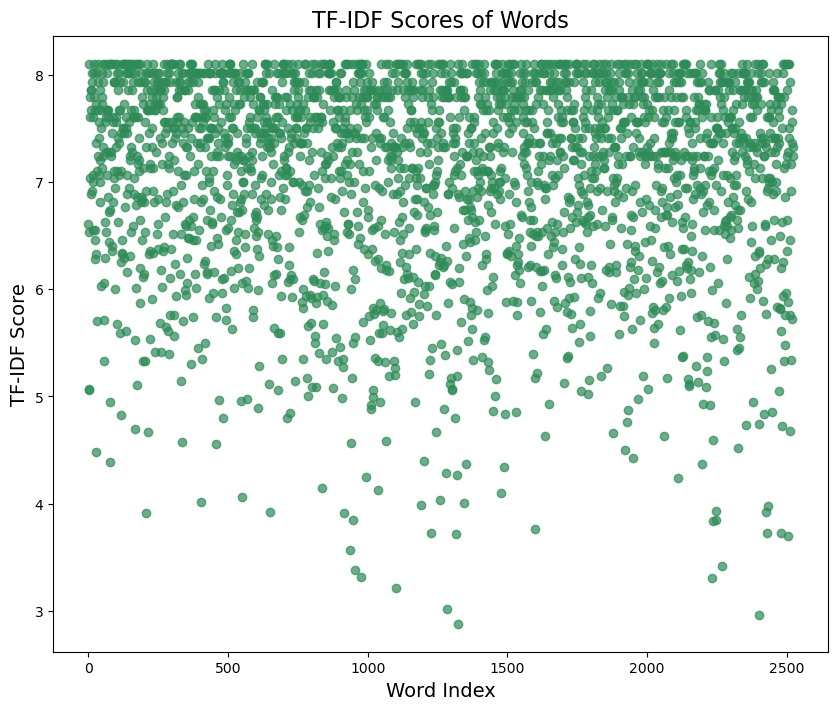

In [449]:
idf_scores = vectorizer.idf_
plt.figure(figsize=(10, 8))
plt.scatter(range(len(idf_scores)), idf_scores, alpha=0.7, marker='o', color='seagreen') 
plt.title('TF-IDF Scores of Words', fontsize=16)
plt.xlabel('Word Index', fontsize=14)
plt.ylabel('TF-IDF Score', fontsize=14)
plt.show()

There are 20958 features which is still huge number of features at the Vocabulary, it can be reduced in the Next Stage

## 6. Modeling & Training

### 6.1 Splitting data for Training & Testing

In [450]:
# Splitting the data into training set (70%) and test set (30%)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30, shuffle=True, random_state=41)

In [451]:
#defining a data frame with the metrics to compare the evaluation performance of the models
result = pd.DataFrame(columns=['Model Name','Accuracy','Precision Score','Recall Score','F1-Score'])

### 6.2 Random Forest Classifier

In [452]:
# Performing hyperparameter tuning for the number of estimators (n_estimator) in the Random Forest Classifier
t_result = []
for i in range(1,11):
    RF = RandomForestClassifier(n_estimators=i, criterion='entropy', n_jobs=-1)
    RF.fit(X_train,y_train)
    prediction = RF.predict(X_train)
    t_result.append((i,accuracy_score(y_train,prediction), precision_score(y_train,prediction), 
                    recall_score(y_train,prediction), f1_score(y_train,prediction)))

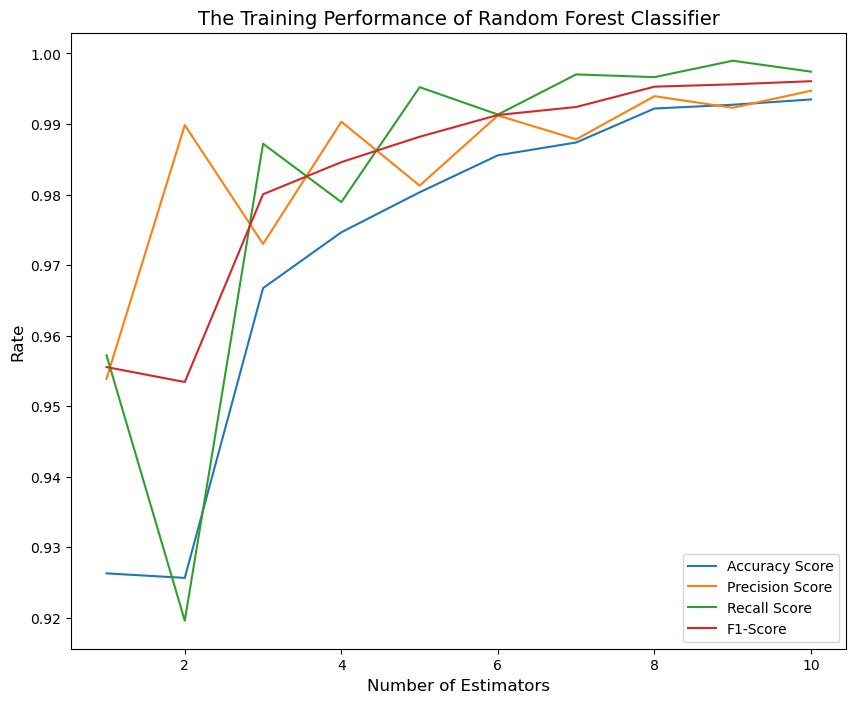

In [453]:
# Plotting the Training Performance
result_df = pd.DataFrame(t_result, columns=['num. of estimator', 'Accuracy', 'Precision','Recall',
                                          'F1-score'])
plt.figure(figsize=(10, 8))
plt.plot(result_df['num. of estimator'], result_df['Accuracy'], label = 'Accuracy Score')
plt.plot(result_df['num. of estimator'], result_df['Precision'], label = 'Precision Score')
plt.plot(result_df['num. of estimator'], result_df['Recall'], label = 'Recall Score')
plt.plot(result_df['num. of estimator'], result_df['F1-score'], label = 'F1-Score')
plt.xlabel("Number of Estimators",fontsize = 12)
plt.ylabel("Rate",fontsize = 12)
plt.title("The Training Performance of Random Forest Classifier",fontsize = 14)
plt.legend()
plt.show()

In [454]:
# Training the classifier on 10 estimators for best performance
RF = RandomForestClassifier(n_estimators= 10, criterion='entropy', n_jobs=-1)
RF.fit(X_train,y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10, n_jobs=-1)

### 6.2.1 Evaluating the Random Forest Classifier

In [455]:
prediction = RF.predict(X_test)
print(classification_report(y_test,prediction))    # Display the Testing Classification Report

              precision    recall  f1-score   support

         0.0       0.68      0.51      0.58       706
         1.0       0.90      0.95      0.92      3302

    accuracy                           0.87      4008
   macro avg       0.79      0.73      0.75      4008
weighted avg       0.86      0.87      0.86      4008



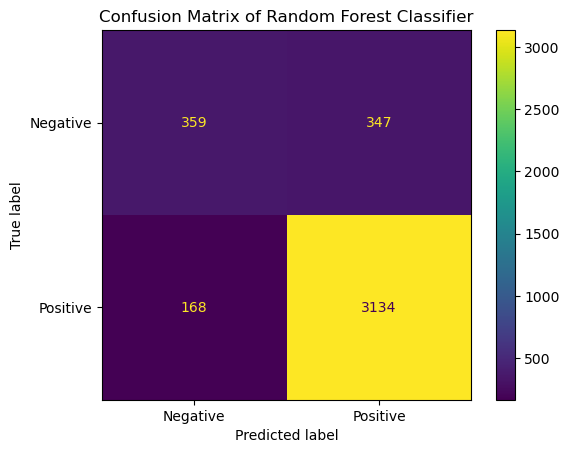

In [456]:
# Displaying the Confusion matrix of Random Forest Classifier
cm_matrix = confusion_matrix(y_test,prediction)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm_matrix, display_labels = ['Negative','Positive'])
cm_display.plot()
plt.title("Confusion Matrix of Random Forest Classifier")
plt.show()

In [457]:
# Storing the evaluation Result of the Random Forest Classifier
model_result = ['Random Forest Classifier',accuracy_score(y_test,prediction), 
              precision_score(y_test,prediction), recall_score(y_test,prediction),
              f1_score(y_test,prediction)]
result.loc[len(result)] = model_result

### 6.3 Logistic Regression

In [458]:
# Performing hyperparameter tuning for C regularization
t_result = []
itr = 0.1
while itr <= 1.00:
    LGR = LogisticRegression(penalty='l2', dual=False, C=itr, fit_intercept=True
                        , random_state = 41, solver = 'sag', max_iter=1000)
    LGR.fit(X_train, y_train)
    prediction = LGR.predict(X_train)
    t_result.append((itr,accuracy_score(y_train,prediction), precision_score(y_train,prediction), 
                    recall_score(y_train,prediction), f1_score(y_train,prediction)))
    itr += 0.1

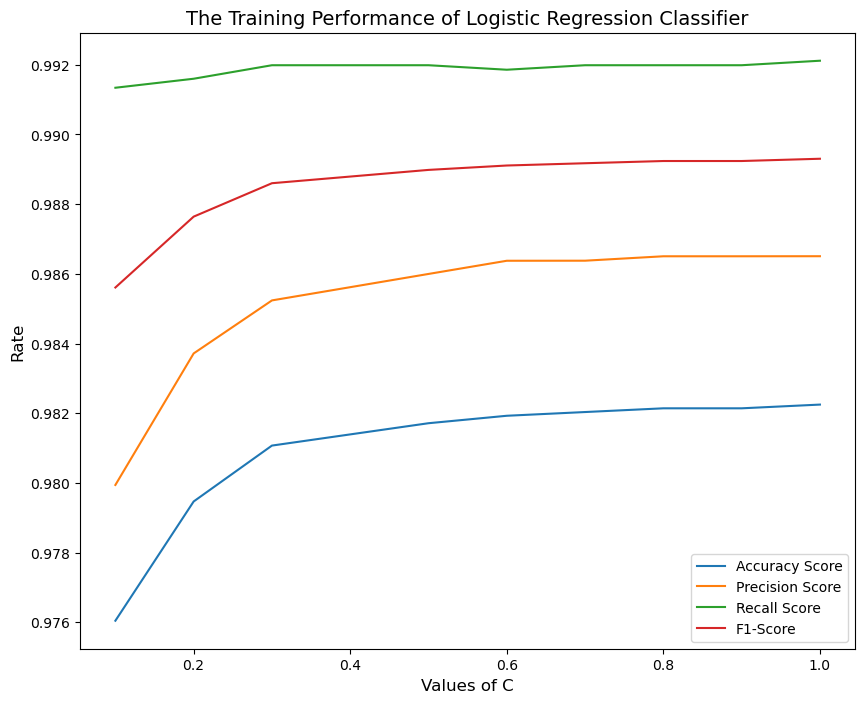

In [459]:
result_df = pd.DataFrame(t_result, columns=['C', 'Accuracy', 'Precision','Recall',
                                          'F1-score'])
plt.figure(figsize=(10, 8))
plt.plot(result_df['C'], result_df['Accuracy'], label = 'Accuracy Score')
plt.plot(result_df['C'], result_df['Precision'], label = 'Precision Score')
plt.plot(result_df['C'], result_df['Recall'], label = 'Recall Score')
plt.plot(result_df['C'], result_df['F1-score'], label = 'F1-Score')
plt.xlabel("Values of C", fontsize = 12)
plt.ylabel("Rate", fontsize = 12)
plt.title("The Training Performance of Logistic Regression Classifier", fontsize = 14)
plt.legend()
plt.show()

In [460]:
# Training the Logistic Regression for C = 0.9 for best performance
LGR = LogisticRegression(penalty='l2', dual=False, C=0.9, fit_intercept=True
                        , random_state = 41, solver = 'sag', max_iter=1000)
LGR.fit(X_train, y_train)

LogisticRegression(C=0.9, max_iter=1000, random_state=41, solver='sag')

### 6.3.1 Evaluating The Logistic Regression model

In [461]:
prediction = LGR.predict(X_test)
print(classification_report(y_test,prediction))    # Display the Testing Classification Report

              precision    recall  f1-score   support

         0.0       0.68      0.64      0.66       706
         1.0       0.92      0.93      0.93      3302

    accuracy                           0.88      4008
   macro avg       0.80      0.79      0.79      4008
weighted avg       0.88      0.88      0.88      4008



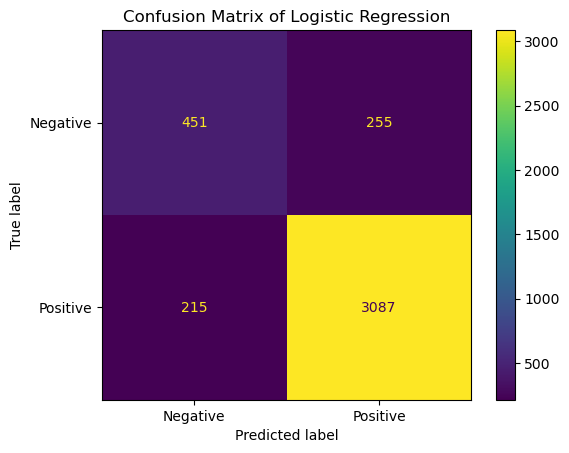

In [462]:
# Displaying the Confusion matrix of Logistic Regression
cm_matrix = confusion_matrix(y_test,prediction)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm_matrix, display_labels = ['Negative','Positive'])
cm_display.plot()
plt.title("Confusion Matrix of Logistic Regression")
plt.show()

In [463]:
#Storing the evaluation Result of Logistic Regression
model_result = ['Logistic Regression',accuracy_score(y_test,prediction), 
              precision_score(y_test,prediction), recall_score(y_test,prediction),
              f1_score(y_test,prediction)]
result.loc[len(result)] = model_result

### 6.4 Multinomial Naive Bayes

In [464]:
NB = MultinomialNB()
NB.fit(X_train,y_train)

MultinomialNB()

In [465]:
print("\t\tThe Training Classification Report")
train_prediction = NB.predict(X_train)
train_report = classification_report(y_train, train_prediction, output_dict=True)
print(classification_report(y_train,train_prediction))    # Display the Training Classification Report
print('\n')
print("\t\tThe Evaluation Classification Report")
test_prediction = NB.predict(X_test)
test_report = classification_report(y_test, test_prediction, output_dict=True)
print(classification_report(y_test,test_prediction))    # Display the Testing Classification Report

		The Training Classification Report
              precision    recall  f1-score   support

         0.0       0.68      0.85      0.76      1614
         1.0       0.97      0.92      0.94      7737

    accuracy                           0.91      9351
   macro avg       0.82      0.88      0.85      9351
weighted avg       0.92      0.91      0.91      9351



		The Evaluation Classification Report
              precision    recall  f1-score   support

         0.0       0.59      0.70      0.64       706
         1.0       0.93      0.89      0.91      3302

    accuracy                           0.86      4008
   macro avg       0.76      0.80      0.77      4008
weighted avg       0.87      0.86      0.86      4008



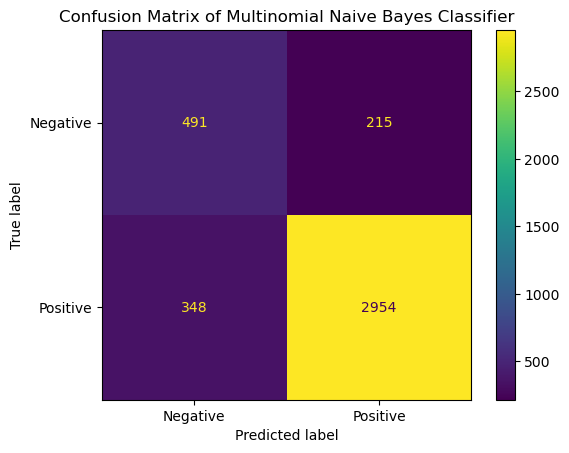

In [466]:
# Displaying the Confusion matrix of Multinomial Naive Bayes
cm_matrix = confusion_matrix(y_test,test_prediction)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm_matrix, display_labels = ['Negative','Positive'])
cm_display.plot()
plt.title("Confusion Matrix of Multinomial Naive Bayes Classifier")
plt.show()

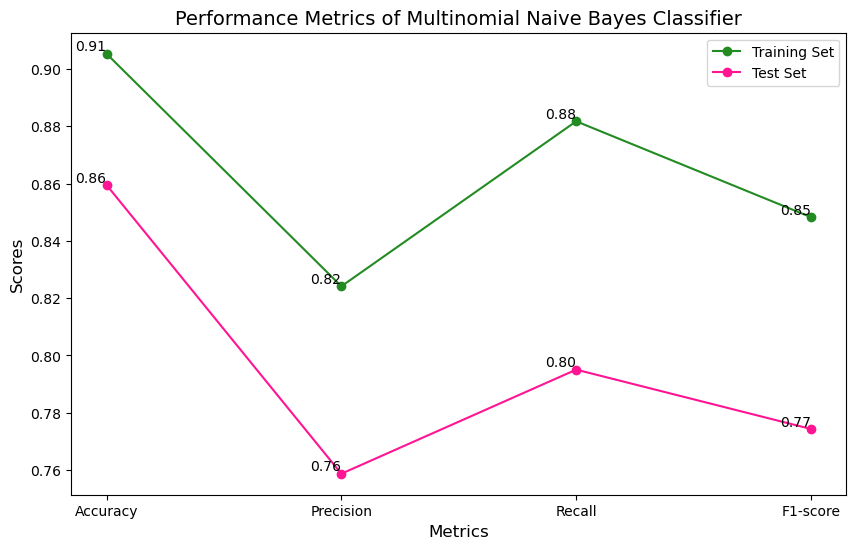

In [467]:
# Extracting metrics for both training and testing sets
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
train_scores = [train_report['accuracy'], train_report['macro avg']['precision'], train_report['macro avg']['recall'], train_report['macro avg']['f1-score']]
test_scores = [test_report['accuracy'], test_report['macro avg']['precision'], test_report['macro avg']['recall'], test_report['macro avg']['f1-score']]
plt.figure(figsize=(10, 6))
plt.plot(metrics, train_scores, marker='o', linestyle='-', label='Training Set', color='forestgreen')
plt.plot(metrics, test_scores, marker='o', linestyle='-', label='Test Set', color='deeppink')
for metric, train_score, test_score in zip(metrics, train_scores, test_scores):
    plt.text(metric, train_score, f'{train_score:.2f}', ha='right', va='bottom', fontsize=10)
    plt.text(metric, test_score, f'{test_score:.2f}', ha='right', va='bottom', fontsize=10)

plt.title('Performance Metrics of Multinomial Naive Bayes Classifier', fontsize = 14)
plt.xlabel('Metrics', fontsize = 12)
plt.ylabel('Scores', fontsize = 12)
plt.legend()
plt.show()

In [468]:
# Storing the evaluation Result of Multinomial Naive Bayes
model_result = ['MultinomialNB',accuracy_score(y_test,test_prediction), 
              precision_score(y_test,test_prediction), recall_score(y_test,test_prediction),
              f1_score(y_test,test_prediction)]
result.loc[len(result)] = model_result

### 6.5 Decision Tree Classifier

In [469]:
#choosing basic hyperparameters for the DTClassifier, with entropy criterion
DT = DecisionTreeClassifier(criterion='entropy', max_features='sqrt')
DT.fit(X_train,y_train)
prediction = DT.predict(X_train)           # Training Performance will be measured

In [470]:
print("\t\tThe Training Classification Report")
prediction = DT.predict(X_train)
print(classification_report(y_train,prediction))    #Print the Training Classification Report
print('\n')
print("\t\tThe Evaluation Classification Report")
prediction = DT.predict(X_test)
print(classification_report(y_test,prediction))    #Print the Testing Classification Report

		The Training Classification Report
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00      1614
         1.0       1.00      1.00      1.00      7737

    accuracy                           1.00      9351
   macro avg       1.00      1.00      1.00      9351
weighted avg       1.00      1.00      1.00      9351



		The Evaluation Classification Report
              precision    recall  f1-score   support

         0.0       0.46      0.46      0.46       706
         1.0       0.89      0.88      0.88      3302

    accuracy                           0.81      4008
   macro avg       0.67      0.67      0.67      4008
weighted avg       0.81      0.81      0.81      4008



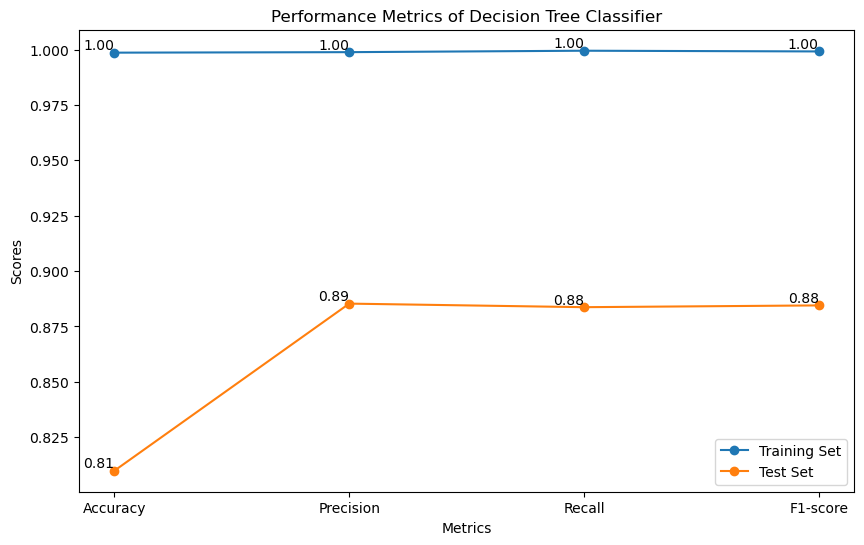

In [471]:
#Plotting performance metrics of Decision Tree Classifier
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
train_scores = [accuracy_score(y_train, DT.predict(X_train)), precision_score(y_train, DT.predict(X_train)), 
                recall_score(y_train, DT.predict(X_train)), f1_score(y_train, DT.predict(X_train))]
test_scores = [accuracy_score(y_test, DT.predict(X_test)), precision_score(y_test, DT.predict(X_test)), 
               recall_score(y_test, DT.predict(X_test)), f1_score(y_test, DT.predict(X_test))]
plt.figure(figsize=(10, 6))
plt.plot(metrics, train_scores, marker='o', label='Training Set')
plt.plot(metrics, test_scores, marker='o', label='Test Set')
for metric, train_score, test_score in zip(metrics, train_scores, test_scores):
    plt.text(metric, train_score, f'{train_score:.2f}', ha='right', va='bottom', fontsize=10)
    plt.text(metric, test_score, f'{test_score:.2f}', ha='right', va='bottom', fontsize=10)
plt.title('Performance Metrics of Decision Tree Classifier')
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.legend()
plt.show()


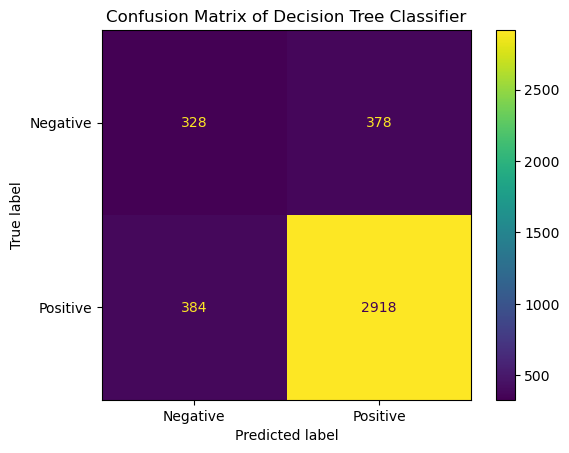

In [472]:
#Displaying the Confusion matrix of Decision Tree Classifier
cm_matrix = confusion_matrix(y_test,prediction)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm_matrix, display_labels = ['Negative','Positive'])
cm_display.plot()
plt.title("Confusion Matrix of Decision Tree Classifier")
plt.show()

In [473]:
#Storing the evaluation Result of DecisionTreeClassifier
model_result = ['DecisionTree',accuracy_score(y_test,prediction), 
              precision_score(y_test,prediction), recall_score(y_test,prediction),
              f1_score(y_test,prediction)]
result.loc[len(result)] = model_result

### 6.6 Linear Support-Vector Classifier

In [474]:
# Performing hyperparameter tuning for C regularization
t_result = []
itr = 0.1
while itr <= 1.00:
    LSVC = LinearSVC(penalty='l2',dual=False, C=itr)
    LSVC.fit(X_train,y_train)
    prediction = LSVC.predict(X_train)
    t_result.append((itr,accuracy_score(y_train,prediction), precision_score(y_train,prediction), 
                    recall_score(y_train,prediction), f1_score(y_train,prediction)))
    itr += 0.1

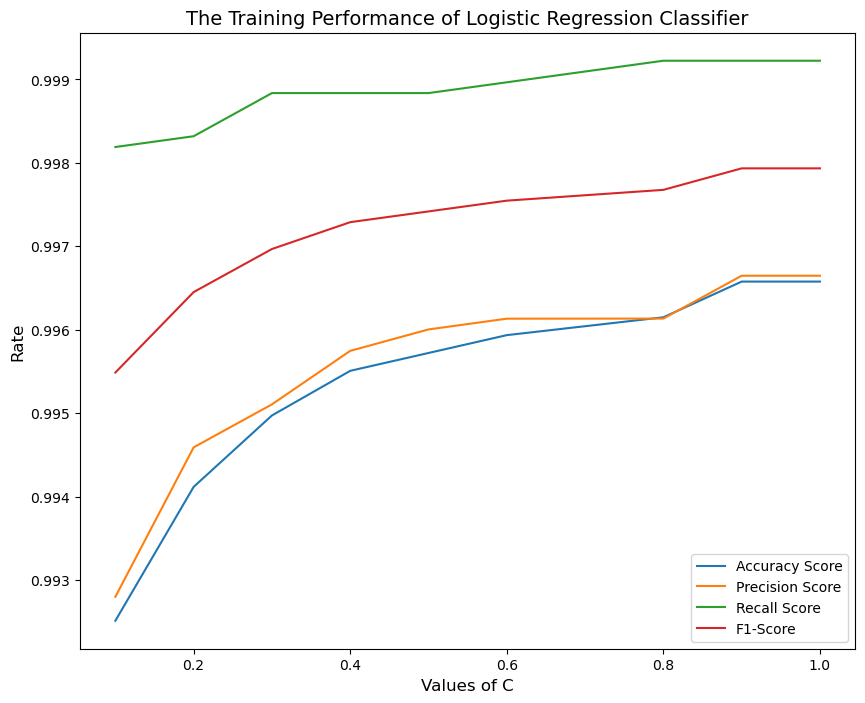

In [475]:
# Displaying the training performance
result_df = pd.DataFrame(t_result, columns=['C', 'Accuracy', 'Precision','Recall',
                                          'F1-score'])
plt.figure(figsize=(10, 8))
plt.plot(result_df['C'], result_df['Accuracy'], label = 'Accuracy Score')
plt.plot(result_df['C'], result_df['Precision'], label = 'Precision Score')
plt.plot(result_df['C'], result_df['Recall'], label = 'Recall Score')
plt.plot(result_df['C'], result_df['F1-score'], label = 'F1-Score')
plt.xlabel("Values of C", fontsize=12)
plt.ylabel("Rate",fontsize=12)
plt.title("The Training Performance of Logistic Regression Classifier",fontsize=14)
plt.legend()
plt.show()

In [476]:
# Training the Linear SVC for C = 0.9 for best performance
LSVC = LinearSVC(penalty='l2',dual=False, C=0.9)
LSVC.fit(X_train,y_train)

LinearSVC(C=0.9, dual=False)

### 6.6.1 Evaluating The Linear Support-Vector Classifier

In [477]:
prediction = LSVC.predict(X_test)
print(classification_report(y_test,prediction))    # Display the Testing Classification Report

              precision    recall  f1-score   support

         0.0       0.58      0.63      0.60       706
         1.0       0.92      0.90      0.91      3302

    accuracy                           0.85      4008
   macro avg       0.75      0.77      0.76      4008
weighted avg       0.86      0.85      0.86      4008



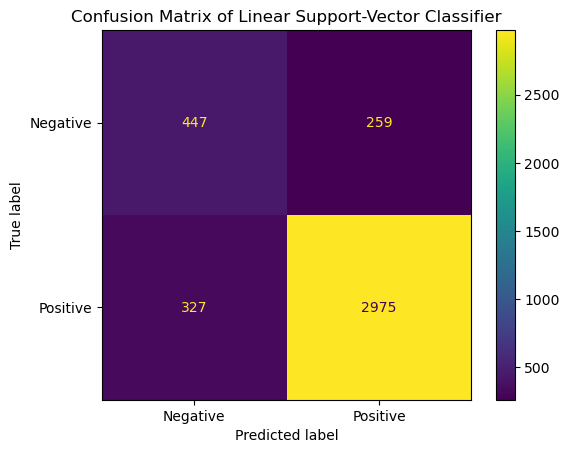

In [478]:
# Displaying the Confusion matrix of Linear SVC
cm_matrix = confusion_matrix(y_test,prediction)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm_matrix, display_labels = ['Negative','Positive'])
cm_display.plot()
plt.title("Confusion Matrix of Linear Support-Vector Classifier")
plt.show()

In [479]:
# Saving the evaluation Result of Linear SVC
model_result = ['Linear SVC',accuracy_score(y_test,prediction), 
              precision_score(y_test,prediction), recall_score(y_test,prediction),
              f1_score(y_test,prediction)]
result.loc[len(result)] = model_result

## 7. Evaluation & Comparison

In [480]:
#Printing the DataFrame containing the Testing Performance of each Model
result

,Model Name,Accuracy,Precision Score,Recall Score,F1-Score
0,Random Forest Classifier,0.871507,0.900316,0.949122,0.924075
1,Logistic Regression,0.882735,0.923698,0.934888,0.929259
2,MultinomialNB,0.859531,0.932155,0.894609,0.912996
3,DecisionTree,0.809880,0.885316,0.883707,0.884510
4,Linear SVC,0.853792,0.919913,0.900969,0.910343


### 7.1 Comparison based on Accuracy

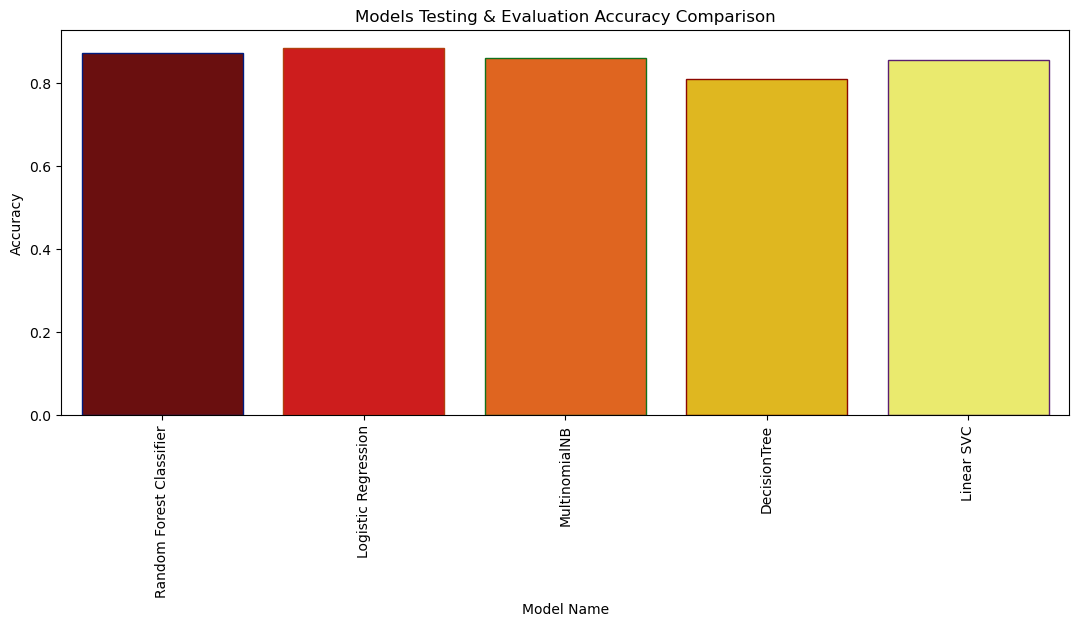

In [481]:
# Displaying a bar to compare between Models according to their Accuracy
plt.subplots(figsize=(13,5))
sns.barplot(x="Model Name", y="Accuracy",data=result,palette='hot',edgecolor=sns.color_palette('dark',7))
plt.xticks(rotation=90)
plt.title('Models Testing & Evaluation Accuracy Comparison')
plt.show()

### 7.2 Comparison based on Precision

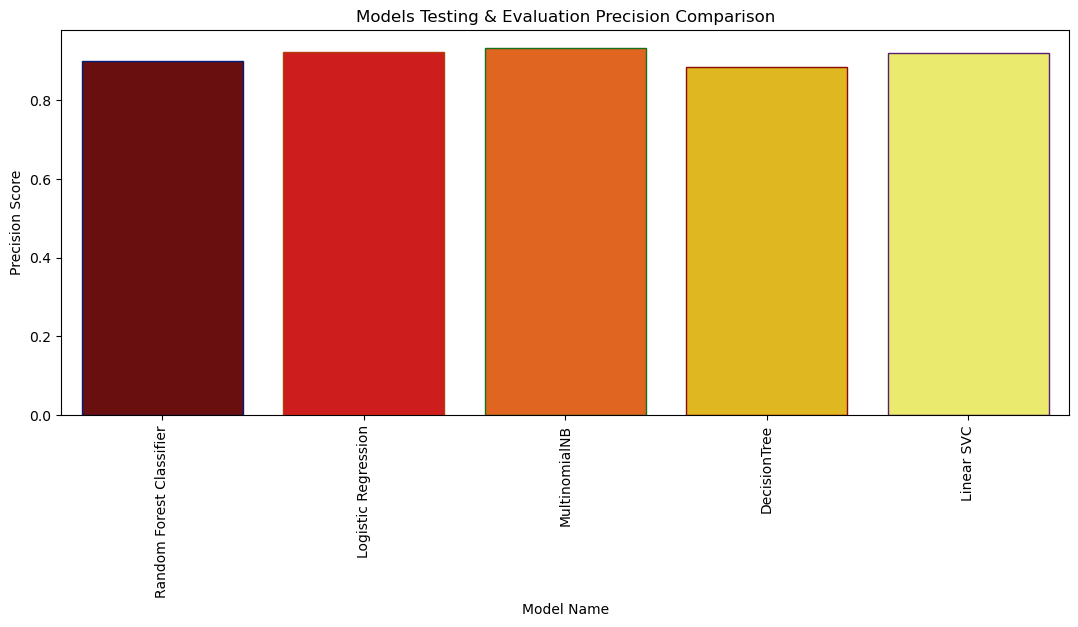

In [482]:
# Displaying a bar to compare between Models according to their Precision
plt.subplots(figsize=(13,5))
sns.barplot(x="Model Name", y="Precision Score",data=result,palette='hot',edgecolor=sns.color_palette('dark',7))
plt.xticks(rotation=90)
plt.title('Models Testing & Evaluation Precision Comparison')
plt.show()

### 7.3 Comparison based on Recall

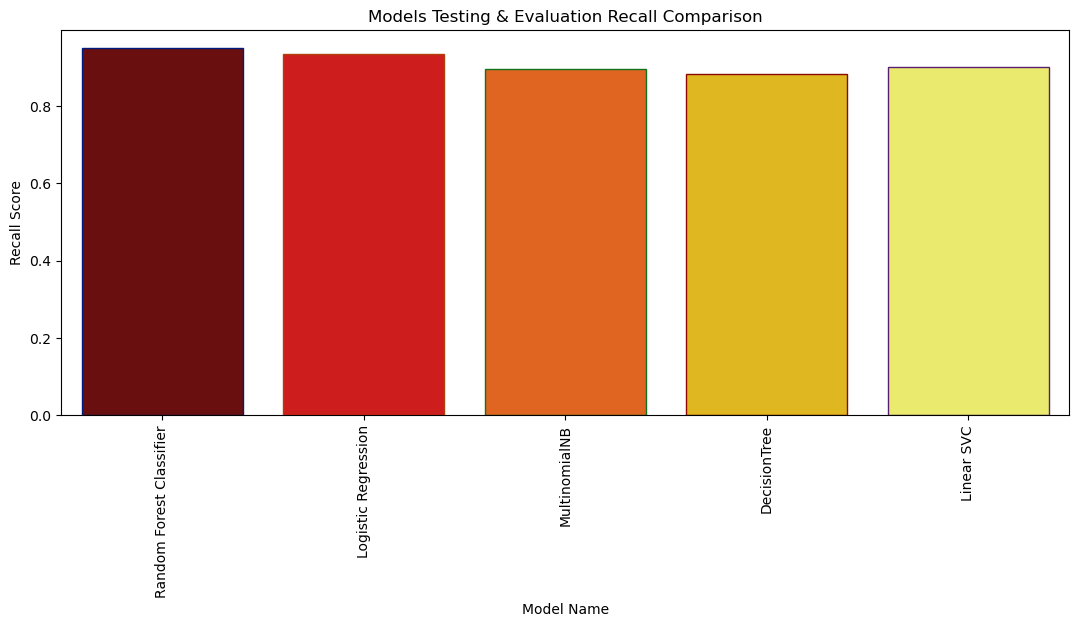

In [483]:
# Displaying a bar to compare between Models according to their Recall
plt.subplots(figsize=(13,5))
sns.barplot(x="Model Name", y="Recall Score",data=result,palette='hot',edgecolor=sns.color_palette('dark',7))
plt.xticks(rotation=90)
plt.title('Models Testing & Evaluation Recall Comparison')
plt.show()

### 7.4 Comparison based on F1-Score

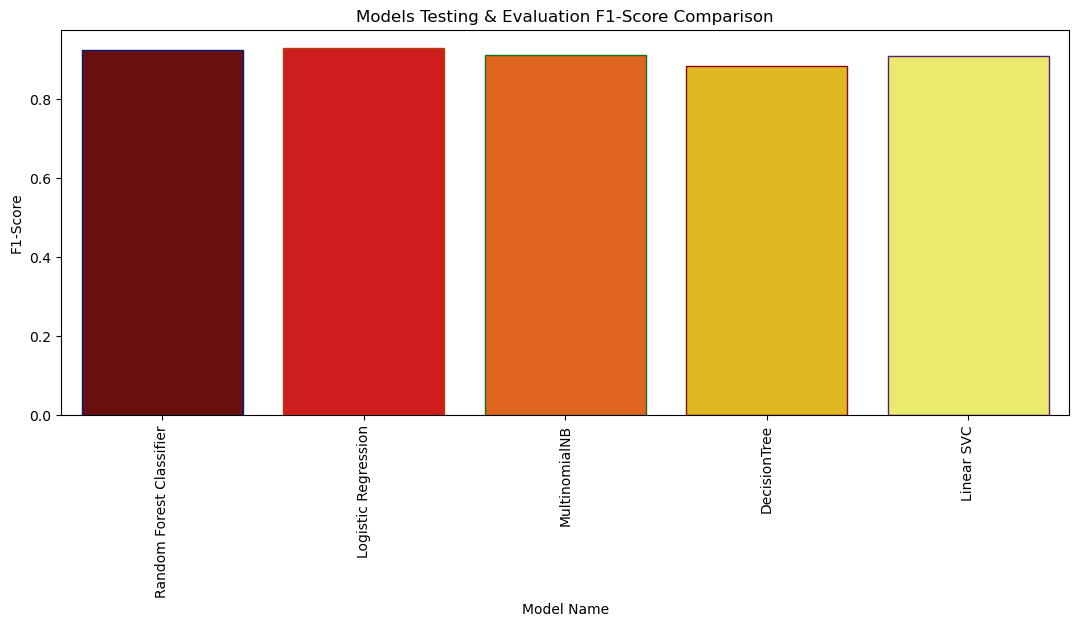

In [484]:
# Displaying a bar to compare between Models according to their F1-score
plt.subplots(figsize=(13,5))
sns.barplot(x="Model Name", y="F1-Score",data=result,palette='hot',edgecolor=sns.color_palette('dark',7))
plt.xticks(rotation=90)
plt.title('Models Testing & Evaluation F1-Score Comparison')
plt.show()

In [485]:
# Assuming you have trained models named RF, LGR, NB, DT, and LSVC

# Initialize a list to store predicted probabilities for each model
predicted_probabilities = []

# Predict probabilities for the testing set for each model
for model_name in ['RF', 'LGR', 'NB', 'DT', 'LSVC']:
    # Get the model object based on its name
    model = globals()[model_name]
    
    # Special handling for LinearSVC
    if model_name == 'LSVC':
        # Initialize SVC with linear kernel and probability=True
        model = SVC(kernel='linear', probability=True)
        # Fit the model
        model.fit(X_train, y_train)
    else:
        # Fit the existing model
        model.fit(X_train, y_train)
    
    # Predict probabilities for the testing set
    # Assuming X_test is your testing data
    predicted_prob = model.predict_proba(X_test)
    
    # For binary classification, use the probability of the positive class
    # For multiclass classification, adjust as needed
    predicted_prob = predicted_prob[:, 1]  # Assuming binary classification
    
    # Append predicted probabilities to the list
    predicted_probabilities.append(predicted_prob)


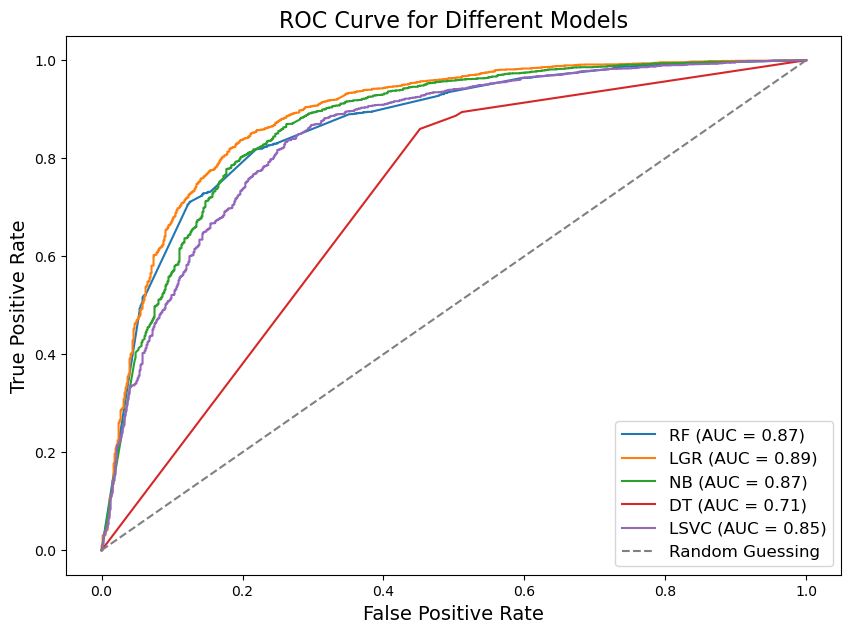

In [486]:
#lists to store fpr, tpr, and auc for each model
roc_auc = []
fpr_list = []
tpr_list = []
plt.subplots(figsize=(10,7))
#Plotting ROC curve for each model
for predicted_prob, model_name, color in zip(predicted_probabilities, ['RF', 'LGR', 'NB', 'DT', 'LSVC'], ['tomato', 'lightseagreen', 'slateblue', 'orange', 'plum']):    
    fpr, tpr, _ = roc_curve(y_test, predicted_prob) #to calculate fpr and tpr
    roc_auc_val = auc(fpr, tpr) #to calculate AUC
    roc_auc.append(roc_auc_val)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    plt.plot(fpr, tpr, label=model_name + ' (AUC = %0.2f)' % roc_auc_val)

plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guessing') #random guessing plot
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curve for Different Models', fontsize=16)
plt.legend(loc='lower right', fontsize = 12)
plt.show()

We can observe that, the ***Logistic Regression Classifier*** provides the **BEST** evaluation performance based on the training performance in the above plots. The model remains consistent across all evaluation metrics. The result suggests that the model generalizes well to unseen data and maintains the predictive power.

Hence, we will proceed with the implementation of a Logistic Regression Classifier to classify the sentiments of the comments.

In [487]:
# Putting All together in Pipeline
LGR_pipe = Pipeline([('vectorizer',vectorizer),('LGR',LGR)])

# Saving the Pipeline for Later using
pickle.dump(LGR_pipe, open('LGR_Model.sav', 'wb'))

In [488]:
from sklearn import set_config
set_config(display='diagram')

LGR_pipe

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(min_df=10, norm=None, strip_accents='ascii')),
                ('LGR',
                 LogisticRegression(C=0.9, max_iter=1000, random_state=41,
                                    solver='sag'))])

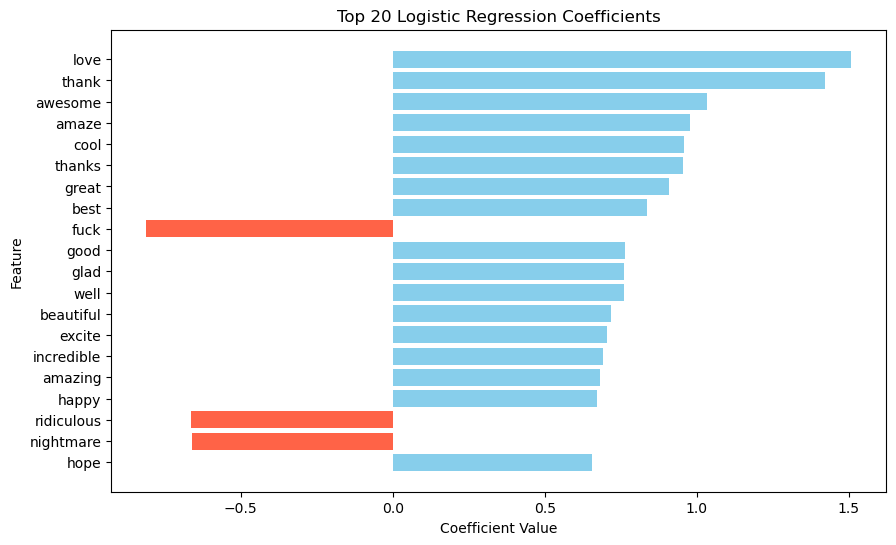

In [489]:
# Get the coefficients of the logistic regression model
coefficients = LGR.coef_[0]

# Sort the coefficients by their absolute values
sorted_indices = np.argsort(np.abs(coefficients))[::-1]
top_n = 20  # Change this to display top N coefficients
top_coefficients = coefficients[sorted_indices][:top_n]
top_features = np.array(vectorizer.get_feature_names_out())[sorted_indices][:top_n]
threshold = 0.0  # Threshold value
colors = ['skyblue' if coef > threshold else 'tomato' for coef in top_coefficients]
# Plot the top N coefficients and their corresponding features
plt.figure(figsize=(10, 6))
plt.barh(np.arange(top_n), top_coefficients, color=colors)
plt.yticks(np.arange(top_n), top_features)
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Top {} Logistic Regression Coefficients'.format(top_n))
plt.gca().invert_yaxis()  # Invert y-axis to display highest coefficients at the top
plt.show()

# 8. Testing our Model

In [490]:
LGR_Model = pickle.load(open('LGR_Model.sav','rb'))           # Loading our model
Sentence = 'I just watched the latest video from my favorite YouTuber, and it was incredibly inspiring! #FeelingMotivated 💪' 
# The sentence to be tested

# Firstly Preprocess the sentence
lower_sen = Sentence.lower()                                  # Lowering all characters
cleaned_sentence = remove_stopwords(lower_sen)                # Removing Stop Words
tken_sentence = word_tokenize(cleaned_sentence)               # Tokenizing to be Lemmatized
lemmatized_sen = lemmatization(tken_sentence)                 # Lemmatization with POS
processed_sen = ' '.join(lemmatized_sen)                      # Regrouping

# Display the Sentence
print(processed_sen)

# Go through the Pipeline (Vectorizing & Predict)
sentiment = LGR_Model.predict([processed_sen])
if sentiment[0] == 1:
    print(Sentence, '(is Positive)')
else:
    print(Sentence, '(is Negative)')

watch late video favorite youtuber , incredibly inspire ! # feelingmotivated 💪
I just watched the latest video from my favorite YouTuber, and it was incredibly inspiring! #FeelingMotivated 💪 (is Positive)
